# Imports and defns

In [11]:
# to reload local packages when debugging
%load_ext autoreload
%autoreload 2

%cd /mnt/c/Users/resha/Documents/Github/balancing_framework/

import pickle
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

base_dir = 'results/runs_picked_for_processing' # stream_trained

def plot_metric(result_sets, metric, focused_form, title):
    plt.figure(figsize=(10, 4))  
    df = pd.DataFrame()

    for result_set_data_form, result_set_data in result_sets.items():
        means1 = np.array([ x[f'{metric}_mean'] for x in result_set_data ])
        # std1 = np.array([ x[f'{metric}_std'] for x in result_set_data ])
        timestamps1 = np.array([ x['last_ts'] for x in result_set_data ])

        # print(set_form_title)
        # print(f'Average Value: {np.mean(means1):.5g}, Highest Value: {np.max(means1):.5g}, Lowest Value: {np.min(means1):.5g}')
        df = pd.concat([df, pd.DataFrame({'mean_acc': np.mean(means1), 'low_acc': np.min(means1), 'high_acc': np.max(means1)}, index=[result_set_data_form])], axis=0)

        if result_set_data_form == 'original + frac_diff': result_set_data_form = 'FD, original in support'
        if result_set_data_form == focused_form:
            sns.lineplot(x=timestamps1, y=means1, label=result_set_data_form, linewidth=1)
        else:
            sns.lineplot(x=timestamps1, y=means1, label=result_set_data_form, linewidth=1)
        
        # plt.fill_between(timestamps1, means1 - std1, means1 + std1, alpha=0.3, label=f'{result_set_data_form} Std Dev')

    # plt.title(title) #(f'{title}: {metric}')
    # plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.legend(fontsize=12, bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", ncol=2)
    
    plt.xticks(fontsize=14,rotation=45) # Adjust X-axis tick label size
    plt.yticks(fontsize=14) # Adjust Y-axis tick label size
    plt.xlabel('Timestamp', fontsize=20)
    plt.ylabel(f'{metric.upper()}', fontsize=20)

    # plt.tight_layout()  
    plt.savefig(f'figures/{title}_{metric}.png', bbox_inches='tight')
    # plt.show()
    
    df = df.reset_index().rename(columns={'index': 'data_form'})
    return df, plt


import os

def load_results(datasets):
    
    ar_res = {}
    cr_res = {}
    for dataset in datasets:
        res_dir = f'{base_dir}/{dataset}'
        ar_res[dataset] = {}
        cr_res[dataset] = {}
        for dir in os.listdir(res_dir):
            if '.' in dir:
                continue

            series_num = dir.split('[')[0].split('_')[-2]
            if series_num not in ar_res[dataset].keys():
                ar_res[dataset][series_num] = {}
                cr_res[dataset][series_num] = {}

            forms_string = dir.split(']')[0].split('[')[1]
            # map form strings to print friendly
            type_map = {"'o'": 'original', "'fd'": 'frac_diff', "'fod'": 'first_order_diff',
                        "'tao'": 'original_ta', "'tafd'": 'frac_diff_ta', "'tafod'": 'first_order_diff_ta',}
            forms_string = ' + '.join([type_map[abbr] for abbr in forms_string.replace(" ", "").split(",")])

            ar, cr = None, None
            try:
                with open(f'{res_dir}/{dir}/adaptation_results.pkl', 'rb') as f:
                    ar = pickle.load(f)
                with open(f'{res_dir}/{dir}/consolidation_results.pkl', 'rb') as f:
                    cr = pickle.load(f)
            except Exception as e:
                print(e)

            # ar_res[dataset][series_num].append((forms_string, ar))
            # cr_res[dataset][series_num].append((forms_string, cr))
            ar_res[dataset][series_num][forms_string] = ar
            cr_res[dataset][series_num][forms_string] = cr
    return ar_res, cr_res


def plot_res_build_resdf(ar_res, cr_res, metric='accuracy'):
    results = pd.DataFrame()
    focused_form = 'original + frac_diff'

    if ar_res:
        for key, value in ar_res.items(): # item = dataset_name, series dict
            dataset = key
            res_dir = f'{base_dir}/{dataset}'
            for key, value in value.items(): # item = series_num, list of results pulled
                series_num = key
                title = f'adap_{dataset}_{series_num}' #f'Comparison of Adaptation {metric} for {dataset}_{series_num}'
                df, plt = plot_metric(value, metric, focused_form, title)
                df['dataset'] = dataset
                df['value_type'] = 'adaptation'
                df['series_num'] = series_num
                results = pd.concat([results, df], ignore_index=True)
                plt.savefig(f'{res_dir}/ada_comp_{metric}_{series_num}.png')
    if cr_res:
        for key, value in cr_res.items(): # item = dataset_name, series dict
            dataset = key
            for key, value in value.items(): # item = series_num, list of results pulled
                series_num = key
                title = f'cons_{dataset}_{series_num}' #f'Comparison of Consolidation {metric} for {dataset}_{series_num}'
                df, plt = plot_metric(value, metric, focused_form, title)
                df['dataset'] = dataset
                df['value_type'] = 'consolidation'
                df['series_num'] = series_num
                results = pd.concat([results, df], ignore_index=True)
                plt.savefig(f'{res_dir}/cons_comp_{metric}_{series_num}.png')

    return results

import itertools
def append_stab(res_pack, results, value_type, metric='accuracy'):
    metric_key = f'{metric}_mean'
    form_keys = ['original', 'frac_diff', 'first_order_diff', 'original_ta', 'frac_diff_ta', 'first_order_diff_ta', 'original, FD in support', 'FD, original in support'] # individual forms
    form_keys = [' + '.join(combo) 
        for r in range(1, len(form_keys) + 1) 
        for combo in itertools.combinations(form_keys, r)
    ] # all combinations of the forms
    
    for dataset in res_pack.keys():
        for series_num in res_pack[dataset].keys():
            for form in form_keys:
                if form in res_pack[dataset][series_num].keys():
                    metric_vals = [ res[metric_key] for res in res_pack[dataset][series_num][form] ]
                    var = np.var(metric_vals)
                    mean = np.mean(metric_vals)
                    print(mean, np.std(metric_vals))
                    coeff_var = (np.std(metric_vals) / np.mean(metric_vals)) * 100
                    # append the values to the passed results df
                    idx = results.loc[results['dataset'] == dataset].loc[ results['value_type'] == value_type].loc[results['series_num'] == series_num].loc[results['data_form'] == form].index
                    results.loc[idx, 'stab_var'] = var
                    results.loc[idx, 'stab_mean'] = mean
                    results.loc[idx, 'stab_coeff_var'] = coeff_var
    return results

# convert index of missing timestamps to datetime using starting point
def impute_ts(res_pack, dataset, starting_point, dataset_length):
    date_lookup = pd.date_range(start=starting_point, periods=dataset_length, freq='D').to_list()
    for series in res_pack[dataset].keys():
        for data_form in res_pack[dataset][series].keys():
            for i, res in enumerate(res_pack[dataset][series][data_form]):
                if type(res['last_ts']) == int or type(res['last_ts']) == np.int64:
                    res_pack[dataset][series][data_form][i]['last_ts'] = date_lookup[res['last_ts']]
    return res_pack



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/mnt/c/Users/resha/Documents/Github/balancing_framework


In [2]:
with open(f'/mnt/c/Users/resha/Downloads/consolidation_results.pkl', 'rb') as f:
    ar = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/c/Users/resha/Downloads/consolidation_results.pkl'

In [6]:
ar

# Run

In [74]:
results[results['dataset'] == 'm4_daily_dataset']

,data_form,mean_acc,low_acc,high_acc,dataset,value_type,series_num,stab_var,stab_mean,stab_coeff_var
0,original + frac_diff + first_order_diff,0.958837,0.915116,0.990698,m4_daily_dataset,adaptation,1165,0.000641,0.958837,2.640366
1,original + frac_diff,0.957326,0.845349,0.995349,m4_daily_dataset,adaptation,1165,0.001565,0.957326,4.132954
2,original + first_order_diff,0.502791,0.432558,0.556977,m4_daily_dataset,adaptation,1165,0.001486,0.502791,7.667620
3,original,0.489070,0.422093,0.526744,m4_daily_dataset,adaptation,1165,0.000895,0.489070,6.116560
16,original + frac_diff + first_order_diff,0.959931,0.946512,0.970203,m4_daily_dataset,consolidation,1165,0.000063,0.959931,0.826453
17,original + frac_diff,0.953133,0.883721,0.973920,m4_daily_dataset,consolidation,1165,0.000807,0.953133,2.980081
18,original + first_order_diff,0.500118,0.472093,0.514922,m4_daily_dataset,consolidation,1165,0.000150,0.500118,2.452465
19,original,0.498533,0.473256,0.511628,m4_daily_dataset,consolidation,1165,0.000110,0.498533,2.099750


In [75]:
a = results[results['dataset'] == 'm4_daily_dataset']
a

,data_form,mean_acc,low_acc,high_acc,dataset,value_type,series_num,stab_var,stab_mean,stab_coeff_var
0,original + frac_diff + first_order_diff,0.958837,0.915116,0.990698,m4_daily_dataset,adaptation,1165,0.000641,0.958837,2.640366
1,original + frac_diff,0.957326,0.845349,0.995349,m4_daily_dataset,adaptation,1165,0.001565,0.957326,4.132954
2,original + first_order_diff,0.502791,0.432558,0.556977,m4_daily_dataset,adaptation,1165,0.001486,0.502791,7.667620
3,original,0.489070,0.422093,0.526744,m4_daily_dataset,adaptation,1165,0.000895,0.489070,6.116560
16,original + frac_diff + first_order_diff,0.959931,0.946512,0.970203,m4_daily_dataset,consolidation,1165,0.000063,0.959931,0.826453
17,original + frac_diff,0.953133,0.883721,0.973920,m4_daily_dataset,consolidation,1165,0.000807,0.953133,2.980081
18,original + first_order_diff,0.500118,0.472093,0.514922,m4_daily_dataset,consolidation,1165,0.000150,0.500118,2.452465
19,original,0.498533,0.473256,0.511628,m4_daily_dataset,consolidation,1165,0.000110,0.498533,2.099750


In [80]:
a = 0.953133
b = 0.498533
print(f'{(a-b)*100:.2f}')

45.46


In [81]:
a = 2.980081 
b = 2.099750
print(f'{((a-b)/a)*100:.2f}')

29.54


In [50]:
a[a['value_type'] == 'adaptation']['stab_coeff_var'].mean() / a[a['value_type'] == 'consolidation']['stab_coeff_var'].mean()

6.01057815343711

In [32]:
form = 'first_order_diff'
all_diffs = []
aa = a[a['value_type'] == 'adaptation']
for i, row in aa.iterrows():
    pct_diff = ((row['mean_acc'] - aa[aa['data_form']==form]['mean_acc'].values[0]) ) * 100
    print(f'{row["data_form"]} > {form} by: {pct_diff:.2f}%')
    all_diffs.append(pct_diff)
ac = a[a['value_type'] == 'consolidation']
for i, row in aa.iterrows():
    pct_diff = ((row['mean_acc'] - ac[ac['data_form']==form]['mean_acc'].values[0]) ) * 100
    print(f'{row["data_form"]} > {form} by: {pct_diff:.2f}%')
    all_diffs.append(pct_diff)

print(f'mean: {np.mean(all_diffs):.2f}')
print(f'std: {np.std(all_diffs):.2f}')

frac_diff > first_order_diff by: 9.07%
first_order_diff > first_order_diff by: 0.00%
original > first_order_diff by: 11.81%
frac_diff > first_order_diff by: 9.88%
first_order_diff > first_order_diff by: 0.80%
original > first_order_diff by: 12.61%
mean: 7.36
std: 5.06


In [52]:
a = 0.7580
b = 0.8987 
print( f'{((b-a)/b)*100:.2f}')


15.66


In [5]:
# convert index of missing timestamps to datetime using starting point
def impute_ts(res_pack, dataset, starting_point, dataset_length):
    date_lookup = pd.date_range(start=starting_point, periods=dataset_length, freq='D').to_list()
    for series in res_pack[dataset].keys():
        for data_form in res_pack[dataset][series].keys():
            for i, res in enumerate(res_pack[dataset][series][data_form]):
                if type(res['last_ts']) == int or type(res['last_ts']) == np.int64:
                    res_pack[dataset][series][data_form][i]['last_ts'] = date_lookup[res['last_ts']]
    return res_pack

In [14]:
ar_res

{'sp500_run5': {'1': {'original + frac_diff': [{'accuracy_mean': nan,
     'f1_mean': nan,
     'accuracy_std': nan,
     'f1_std': nan,
     'mape_mean': 0.12367126680441046,
     'mape_std': 0.006621242370987378,
     'rmse_mean': 15.172254532038654,
     'rmse_std': 0.8020354526905527,
     'mase_mean': 16.69181455478227,
     'mase_std': 0.8936735676378225,
     'smape_mean': 0.1321017516441557,
     'smape_std': 0.007569618834502148,
     'time_training_seconds': 45.95913628319977,
     'time_test_seconds': nan,
     'model_name': 'ffn',
     'last_ts': Timestamp('2005-02-15 14:35:00-0500', tz='America/New_York')},
    {'accuracy_mean': nan,
     'f1_mean': nan,
     'accuracy_std': nan,
     'f1_std': nan,
     'mape_mean': 0.13009011830499423,
     'mape_std': 0.0016187763365430117,
     'rmse_mean': 16.179435674771565,
     'rmse_std': 0.18630645932953585,
     'mase_mean': 19.41401727739885,
     'mase_std': 0.24146277430983734,
     'smape_mean': 0.13943141897399938,
     'sm

In [16]:
with open('/mnt/c/Users/resha/Documents/Github/balancing_framework/spy5m_bintp_labelled.pkl', 'rb') as f:
    df_original = pickle.load(f) # ohlv + transactions + labels + bintp labels
df_original.drop(df_original[df_original['high'] == df_original['low']].index, inplace=True)
        

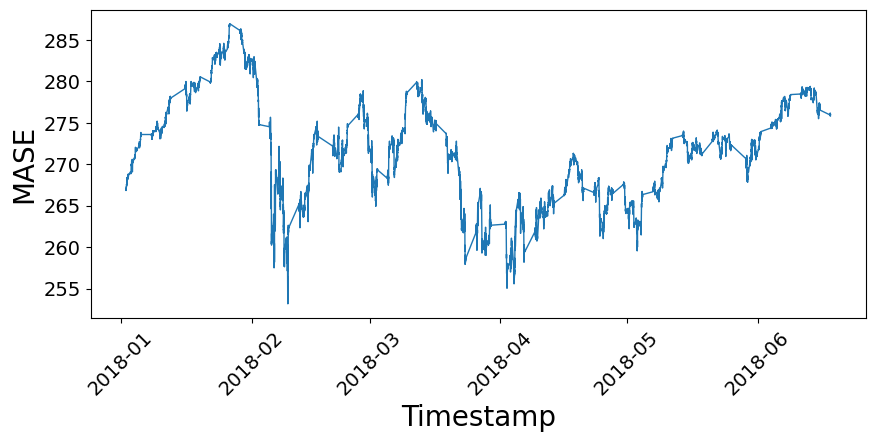

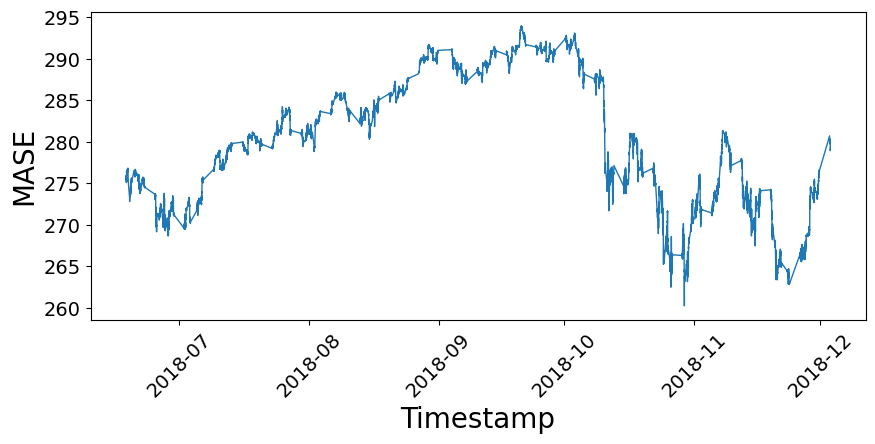

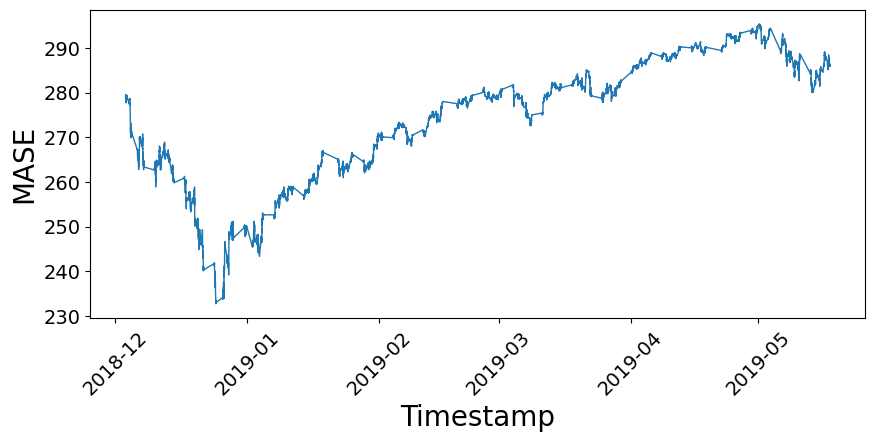

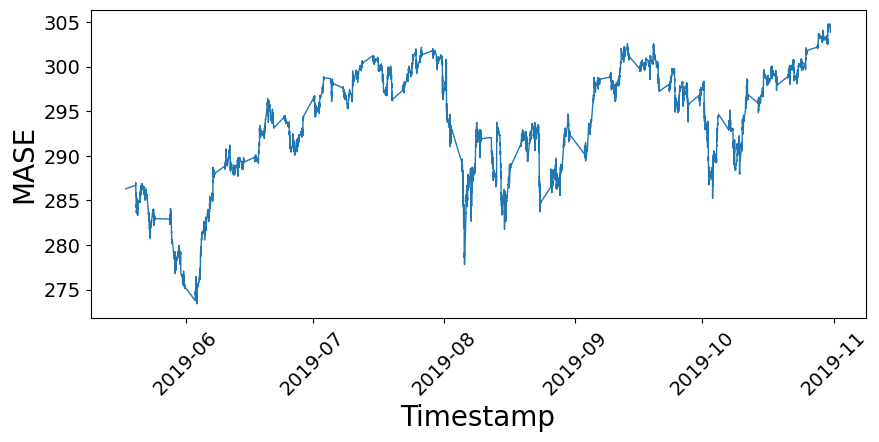

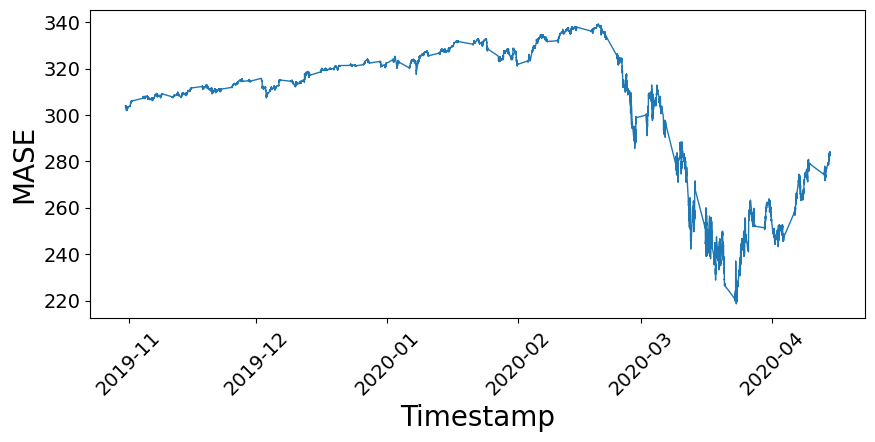

In [19]:

tmps = []
tmps.append(df_original['01-01-2018':"2018-06-18 06:10:00"].close) # batch 1
tmps.append(df_original["2018-06-18 06:10:00":"2018-12-03 11:00:00"].close) # batch 2
tmps.append(df_original["2018-12-03 11:00:00":"2019-05-17 19:40:00"].close) # batch 3
tmps.append(df_original["2019-05-17 19:40:00":"2019-10-31 05:10:00"].close) # batch 4
tmps.append(df_original["2019-10-31 05:10:00":"2020-04-14 15:15:00"].close) # batch 5



import seaborn as sns
import matplotlib.pyplot as plt

for i, tmp in enumerate(tmps):
    plt.figure(figsize=(10, 4))
    sns.lineplot(x=tmp.index, y=tmp.values, linewidth=1)

    # plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    # plt.legend(fontsize=12, bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", ncol=2)

    plt.xticks(fontsize=14,rotation=45) # Adjust X-axis tick label size
    plt.yticks(fontsize=14) # Adjust Y-axis tick label size
    plt.xlabel('Timestamp', fontsize=20)
    plt.ylabel('MASE', fontsize=20)

    # plt.tight_layout()  
    plt.savefig(f'figures/chronos_ot_batch_{i}_series.png', bbox_inches='tight')


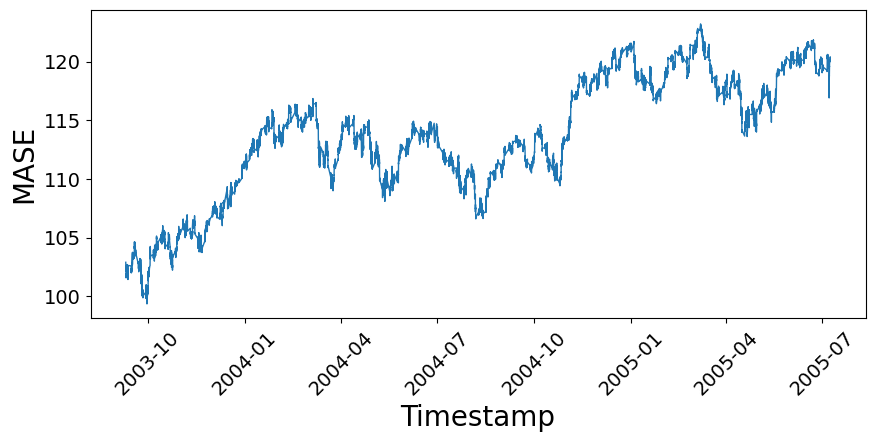

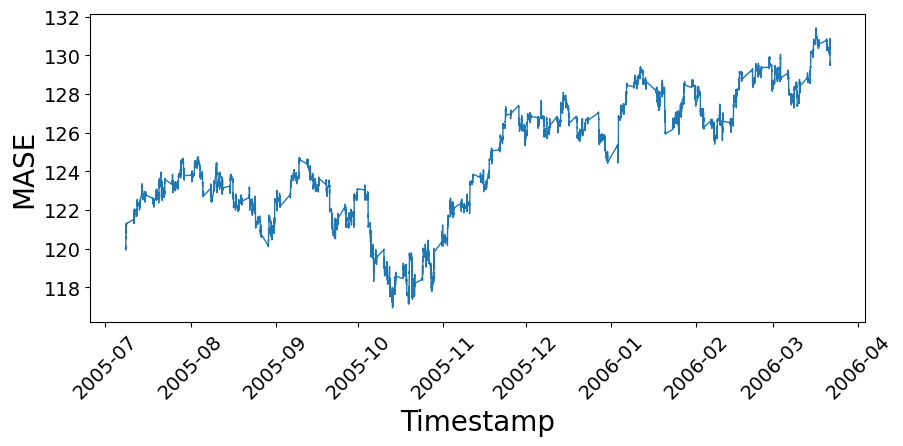

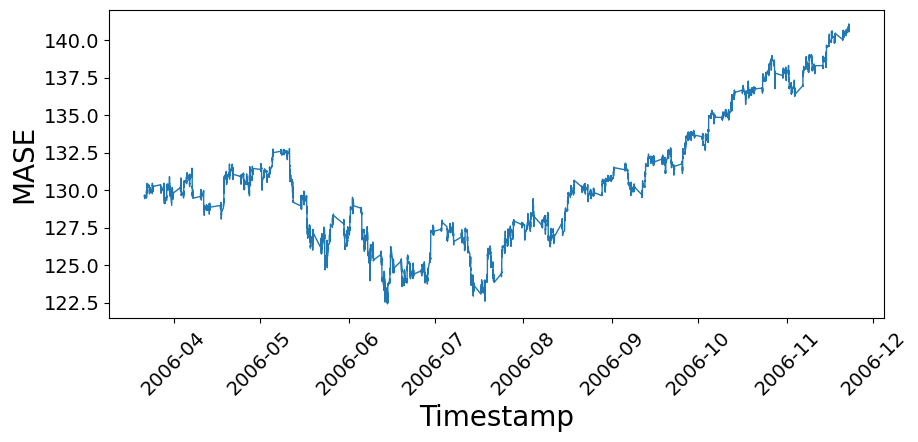

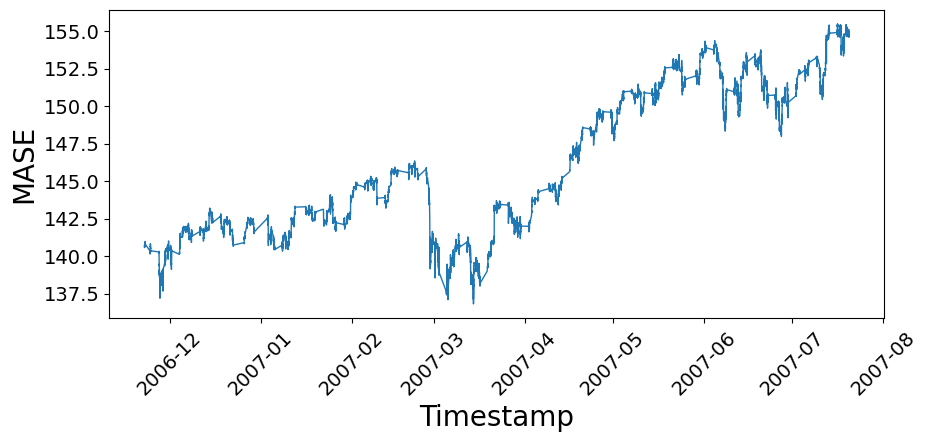

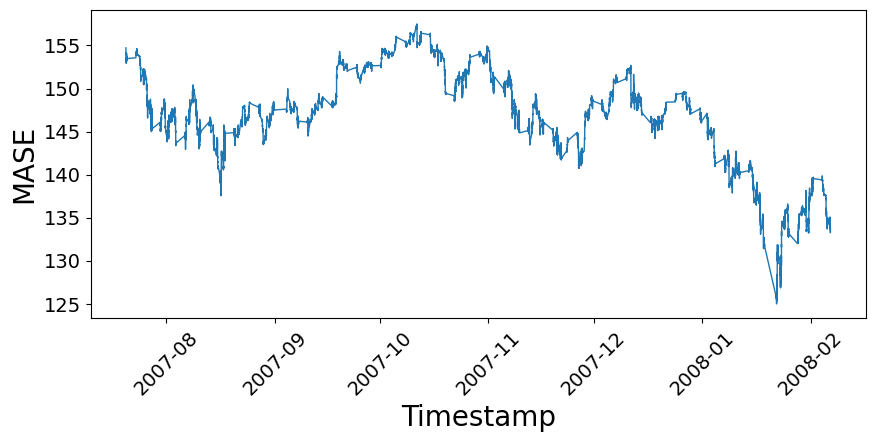

In [36]:
tmps = []
tmps.append(df_original[:'2005-07-08 09:20:00-04:00'].close) # batch 1
tmps.append(df_original['2005-07-08 09:20:00':'2006-03-21 17:05:00'].close) # batch 2
tmps.append(df_original['2006-03-21 17:05:00':'2006-11-22 11:45:00'].close) # batch 3
tmps.append(df_original['2006-11-22 11:45:00':'2007-07-20 09:45:00'].close) # batch 4
tmps.append(df_original['2007-07-20 09:45:00':'2008-02-06 15:45:00'].close) # batch 5



import seaborn as sns
import matplotlib.pyplot as plt

for i, tmp in enumerate(tmps):
    plt.figure(figsize=(10, 4))
    sns.lineplot(x=tmp.index, y=tmp.values, linewidth=1)

    # plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    # plt.legend(fontsize=12, bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", ncol=2)

    plt.xticks(fontsize=14,rotation=45) # Adjust X-axis tick label size
    plt.yticks(fontsize=14) # Adjust Y-axis tick label size
    plt.xlabel('Timestamp', fontsize=20)
    plt.ylabel('MASE', fontsize=20)

    # plt.tight_layout()  
    plt.savefig(f'figures/dl_ot_batch_{i}_series.png', bbox_inches='tight')


In [32]:
for res in ar_res['sp500_run5']['1']['original + frac_diff']:
    print(res['last_ts'])

2005-07-08 09:20:00-04:00
2006-03-21 17:05:00-05:00
2006-11-22 11:45:00-05:00
2007-07-20 09:45:00-04:00
2008-02-06 15:45:00-05:00


In [14]:
print(results[['dataset', 'value_type', 'data_form', 'mean_acc', 'low_acc', 'high_acc', 'stab_coeff_var']].to_latex(index=False, float_format="%.4f"))

\begin{tabular}{lllrrrr}
\toprule
dataset & value_type & data_form & mean_acc & low_acc & high_acc & stab_coeff_var \\
\midrule
sp500_run6 & adaptation & original & 3.1844 & 1.0342 & 6.7068 & 75.3827 \\
sp500_run6 & adaptation & original, FD in support & 3.0886 & 0.9872 & 7.1612 & 79.2960 \\
sp500_run6 & adaptation & FD, original in support & 2.3601 & 1.0440 & 4.3016 & 53.7765 \\
\bottomrule
\end{tabular}



In [7]:
original_mases = [1.2464328924256447, 6.706800540233095, 1.4841876084121053, 1.0342057986392927, 5.450332046424379]
fdinfdr_mases = [0.9871602830258746, 7.1612000211493765, 1.267377903348882, 1.3312123180605897, 4.695928078978678]
fdtarget_mases = [1.1943751252418298, 3.353997748515437, 1.9064051352863358, 1.0440277604942618, 4.301556207809161]
tss = ["2018-06-18 06:10:00-04:00", "2018-12-03 11:00:00-05:00", "2019-05-17 19:40:00-04:00", "2019-10-31 05:10:00-04:00", "2020-04-14 15:15:00-04:00"]
tss = [pd.Timestamp(x) for x in tss]

3.184391777226904 2.4004802600572934
3.0885757209126803 2.4491175862677883
2.360072395469405 1.2691638657817106


,data_form,mean_acc,low_acc,high_acc,dataset,value_type,series_num,stab_var,stab_mean,stab_coeff_var
0,original,3.184392,1.034206,6.706801,sp500_run6,adaptation,1,5.762305,3.184392,75.382692
1,"original, FD in support",3.088576,0.987160,7.161200,sp500_run6,adaptation,1,5.998177,3.088576,79.296019
2,"FD, original in support",2.360072,1.044028,4.301556,sp500_run6,adaptation,1,1.610777,2.360072,53.776480


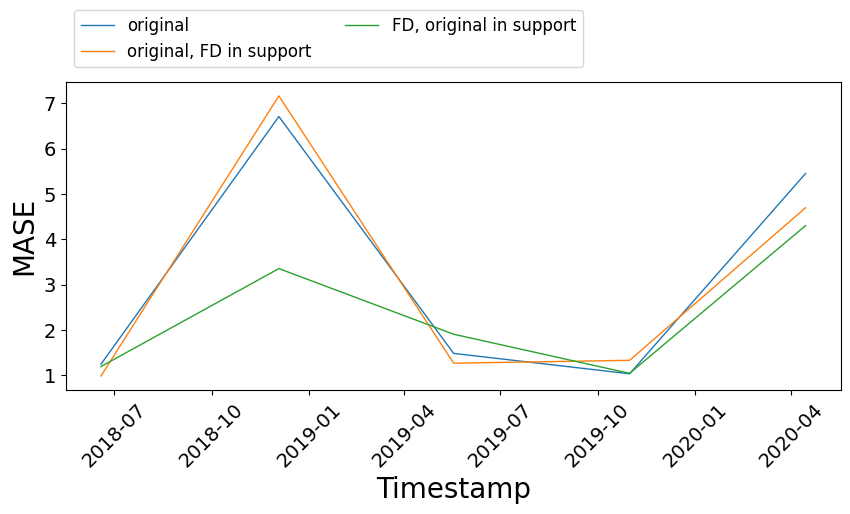

In [12]:
ar_res = {'sp500_run6': {'1': {}}}
ar_res['sp500_run6']['1']['original'] = [{'mase_mean':x, 'last_ts':y} for x,y in zip(original_mases, tss)]
ar_res['sp500_run6']['1']['original, FD in support'] = [{'mase_mean':x, 'last_ts':y} for x,y in zip(fdinfdr_mases, tss)]
ar_res['sp500_run6']['1']['FD, original in support'] = [{'mase_mean':x, 'last_ts':y} for x,y in zip(fdtarget_mases, tss)]

results = plot_res_build_resdf(ar_res, None, metric='mase')

results = append_stab(ar_res, results, 'adaptation', metric='mase')
results

In [ ]:
ar_res

[Errno 2] No such file or directory: "results/runs_picked_for_processing/sp500_run5/sp500_run5_1_['o', 'fd']_chunk_size=20000_num_runs=10_ffn/consolidation_results.pkl"
[Errno 2] No such file or directory: "results/runs_picked_for_processing/sp500_run5/sp500_run5_1_['o']_chunk_size=20000_num_runs=10_ffn/consolidation_results.pkl"
[Errno 2] No such file or directory: "results/runs_picked_for_processing/sp500_run51/sp500_run51_1_['o', 'fd']_chunk_size=20000_num_runs=10_transformer/consolidation_results.pkl"
[Errno 2] No such file or directory: "results/runs_picked_for_processing/sp500_run51/sp500_run51_1_['o']_chunk_size=20000_num_runs=10_transformer/consolidation_results.pkl"
[Errno 2] No such file or directory: "results/runs_picked_for_processing/sp500_run52/sp500_run52_1_['o', 'fd']_chunk_size=20000_num_runs=10_wavenet/consolidation_results.pkl"
[Errno 2] No such file or directory: "results/runs_picked_for_processing/sp500_run52/sp500_run52_1_['o']_chunk_size=20000_num_runs=10_wavenet

,data_form,mean_acc,low_acc,high_acc,dataset,value_type,series_num,stab_var,stab_mean,stab_coeff_var
0,original + frac_diff,0.647476,0.222912,1.037217,sp500_run5,adaptation,1,0.092982,0.647476,47.094975
1,original,1.246097,0.284932,1.927070,sp500_run5,adaptation,1,0.294304,1.246097,43.535796
2,original + frac_diff,0.860040,0.481711,1.161362,sp500_run51,adaptation,1,0.067487,0.860040,30.205880
3,original,1.533669,0.698485,2.538464,sp500_run51,adaptation,1,0.397582,1.533669,41.113241
4,original + frac_diff,0.759267,0.294497,1.472475,sp500_run52,adaptation,1,0.155617,0.759267,51.955730
5,original,1.432805,0.958974,2.860307,sp500_run52,adaptation,1,0.519023,1.432805,50.281236


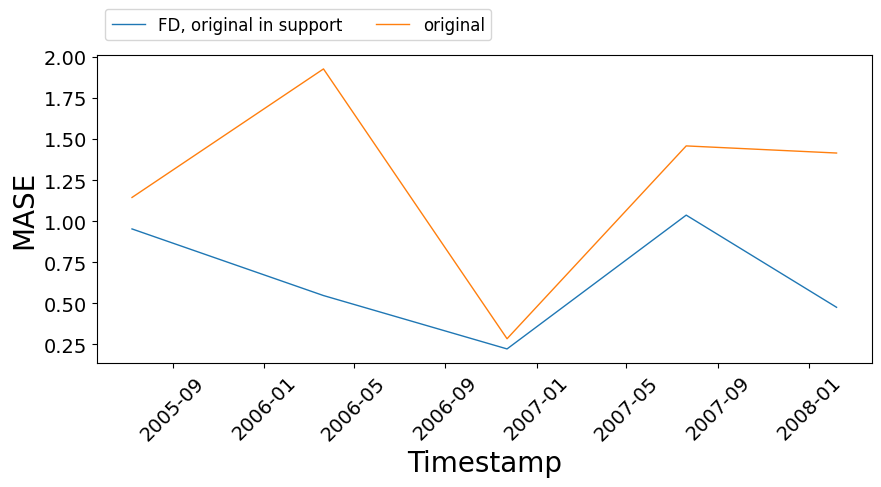

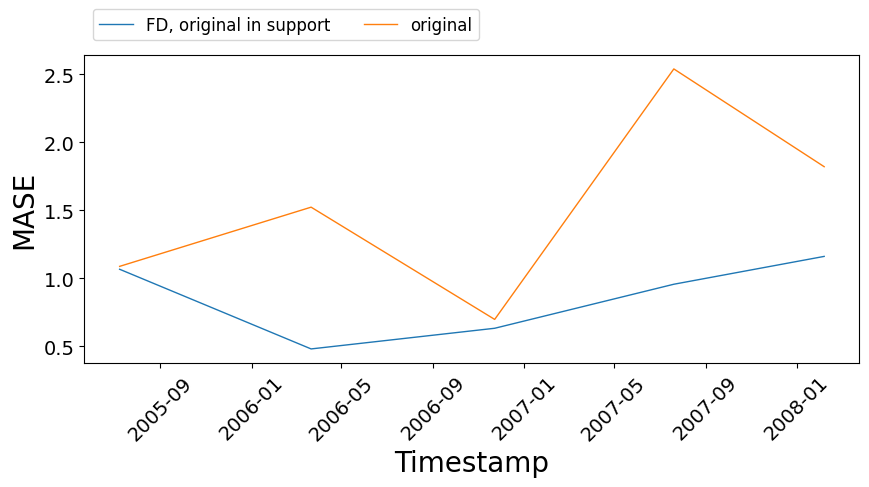

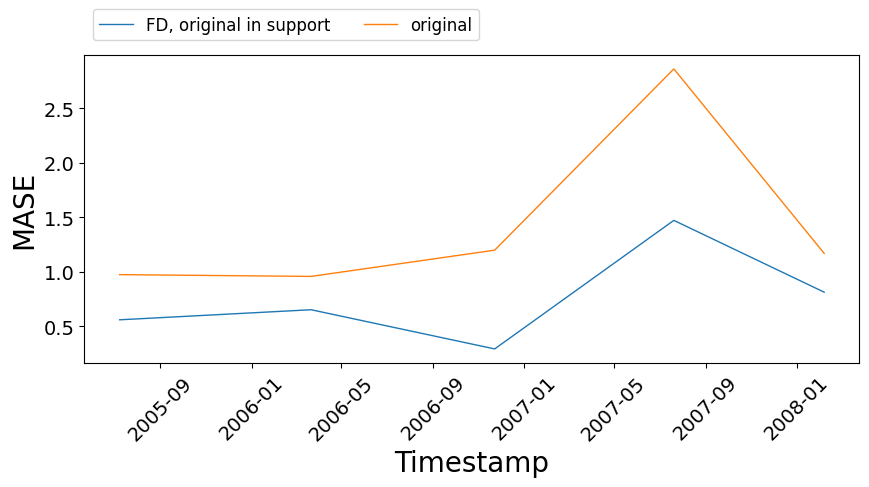

In [2]:
datasets = ['sp500_run5', 'sp500_run51', 'sp500_run52'] # still run5, transformer is run51 or run 5.1

ar_res, _ = load_results(datasets)

# ar_res = impute_ts(ar_res, 'm4_daily_dataset', '1997-07-22', 8531)
# cr_res = impute_ts(cr_res, 'm4_daily_dataset', '1997-07-22', 8531)

results = plot_res_build_resdf(ar_res, None, metric='mase')

results = append_stab(ar_res, results, 'adaptation', metric='mase')
# results = append_stab(cr_res, results, 'consolidation')
results

In [5]:
results['dataset'] = results['dataset'].str.replace('sp500_run5', 'S\&P 500 (Run 5)').str.replace('sp500_run51', 'S\&P 500 (Run 5)').str.replace('sp500_run52', 'S\&P 500 (Run 5) ')
results['data_form'] = results['data_form'].str.replace('frac_diff', 'FD').str.replace('original', 'O').str.replace('first_order_diff', 'FOD').str.replace('_ta', ' (+df)').str.replace(' +', ',')
results = results[['dataset', 'value_type', 'data_form', 'mean_acc', 'low_acc', 'high_acc', 'stab_coeff_var']]
results

,dataset,value_type,data_form,mean_acc,low_acc,high_acc,stab_coeff_var
0,S\&P 500 (Run 5),adaptation,"O, FD",0.647476,0.222912,1.037217,47.094975
1,S\&P 500 (Run 5),adaptation,O,1.246097,0.284932,1.927070,43.535796
2,S\&P 500 (Run 5)1,adaptation,"O, FD",0.860040,0.481711,1.161362,30.205880
3,S\&P 500 (Run 5)1,adaptation,O,1.533669,0.698485,2.538464,41.113241
4,S\&P 500 (Run 5)2,adaptation,"O, FD",0.759267,0.294497,1.472475,51.955730
5,S\&P 500 (Run 5)2,adaptation,O,1.432805,0.958974,2.860307,50.281236


In [7]:
print(results.to_latex(index=False, float_format="%.4f"))

\begin{tabular}{lllrrrr}
\toprule
dataset & value_type & data_form & mean_acc & low_acc & high_acc & stab_coeff_var \\
\midrule
S\&P 500 (Run 5) & adaptation & O, FD & 0.6475 & 0.2229 & 1.0372 & 47.0950 \\
S\&P 500 (Run 5) & adaptation & O & 1.2461 & 0.2849 & 1.9271 & 43.5358 \\
S\&P 500 (Run 5)1 & adaptation & O, FD & 0.8600 & 0.4817 & 1.1614 & 30.2059 \\
S\&P 500 (Run 5)1 & adaptation & O & 1.5337 & 0.6985 & 2.5385 & 41.1132 \\
S\&P 500 (Run 5)2 & adaptation & O, FD & 0.7593 & 0.2945 & 1.4725 & 51.9557 \\
S\&P 500 (Run 5)2 & adaptation & O & 1.4328 & 0.9590 & 2.8603 & 50.2812 \\
\bottomrule
\end{tabular}



,data_form,mean_acc,low_acc,high_acc,dataset,value_type,series_num,stab_var,stab_mean,stab_coeff_var
0,original + frac_diff + first_order_diff,0.958837,0.915116,0.990698,m4_daily_dataset,adaptation,1165,0.000641,0.958837,2.640366
1,original + frac_diff,0.957326,0.845349,0.995349,m4_daily_dataset,adaptation,1165,0.001565,0.957326,4.132954
2,original + first_order_diff,0.502791,0.432558,0.556977,m4_daily_dataset,adaptation,1165,0.001486,0.502791,7.667620
3,original,0.489070,0.422093,0.526744,m4_daily_dataset,adaptation,1165,0.000895,0.489070,6.116560
4,frac_diff,0.663071,0.546500,0.849300,sp500_run1,adaptation,1,0.003516,0.663071,8.942310
5,first_order_diff,0.572326,0.489600,0.743100,sp500_run1,adaptation,1,0.002514,0.572326,8.760292
6,original,0.690385,0.552600,0.867700,sp500_run1,adaptation,1,0.003948,0.690385,9.101097
7,original + frac_diff + first_order_diff,0.795817,0.680800,0.930100,sp500_run2,adaptation,1,0.003352,0.795817,7.275011
8,original + frac_diff,0.829648,0.740600,0.932700,sp500_run2,adaptation,1,0.002211,0.829648,5.667216
9,original + first_order_diff,0.683492,0.562800,0.860000,sp500_run2,adaptation,1,0.003845,0.683492,9.072673


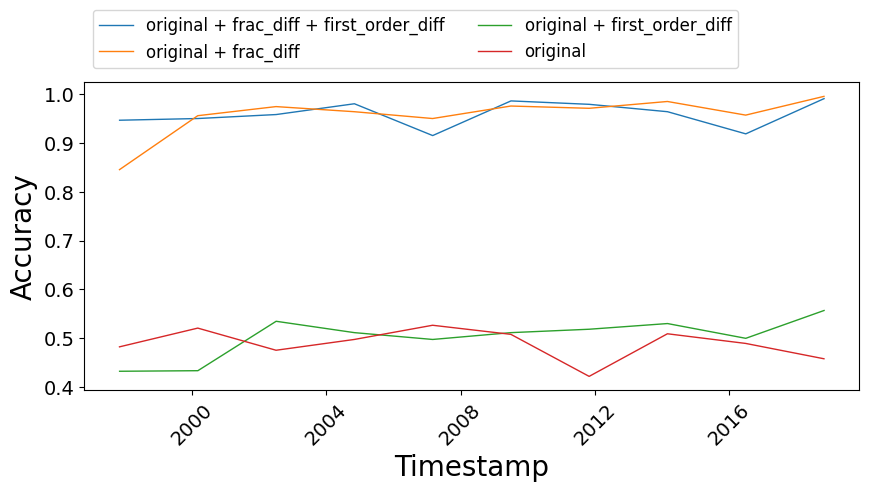

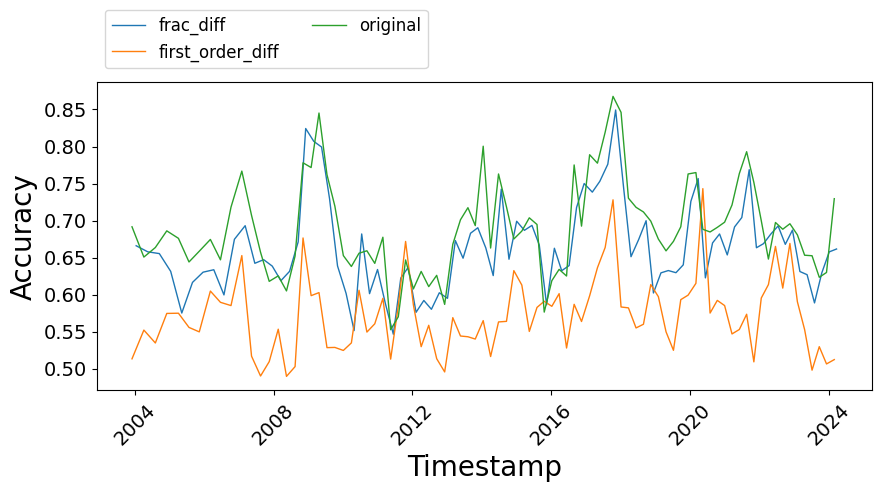

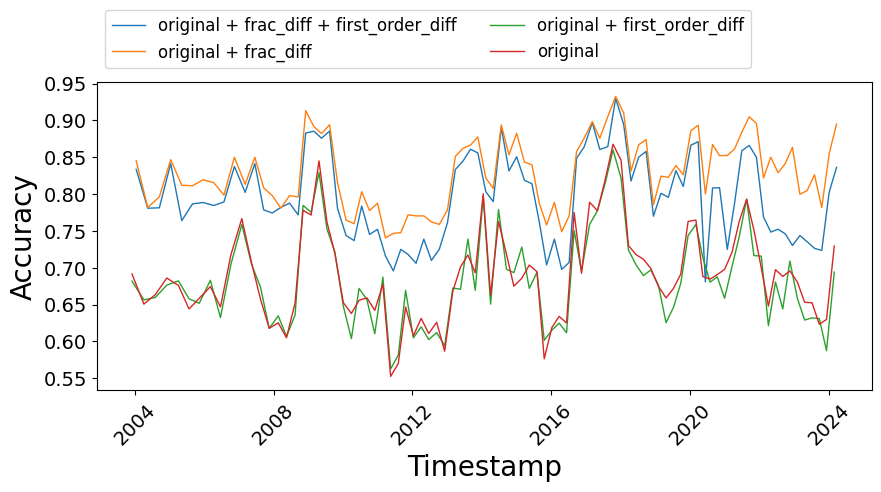

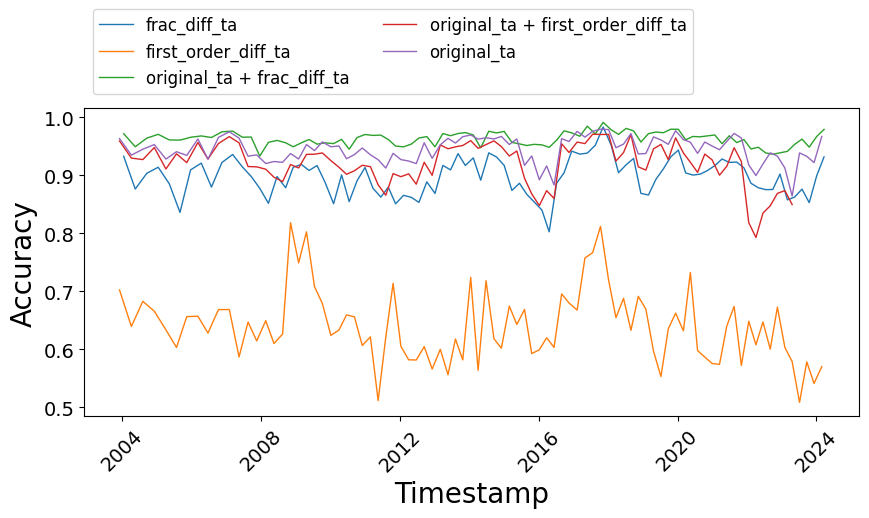

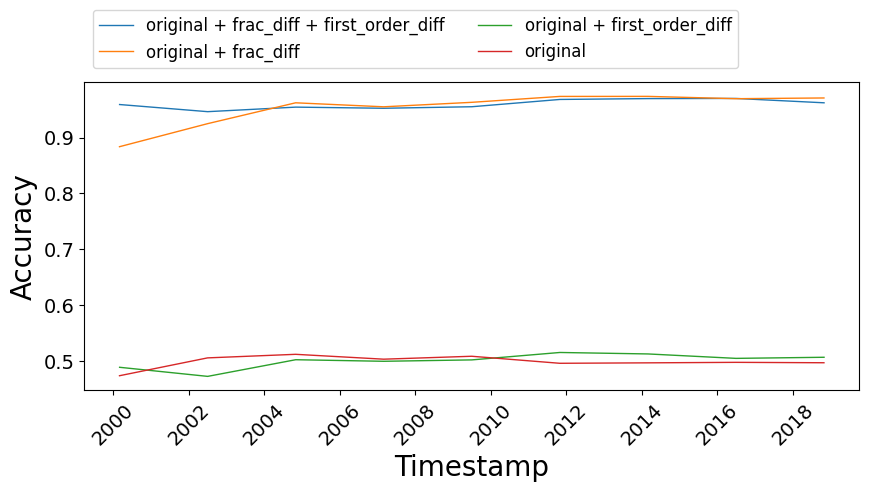

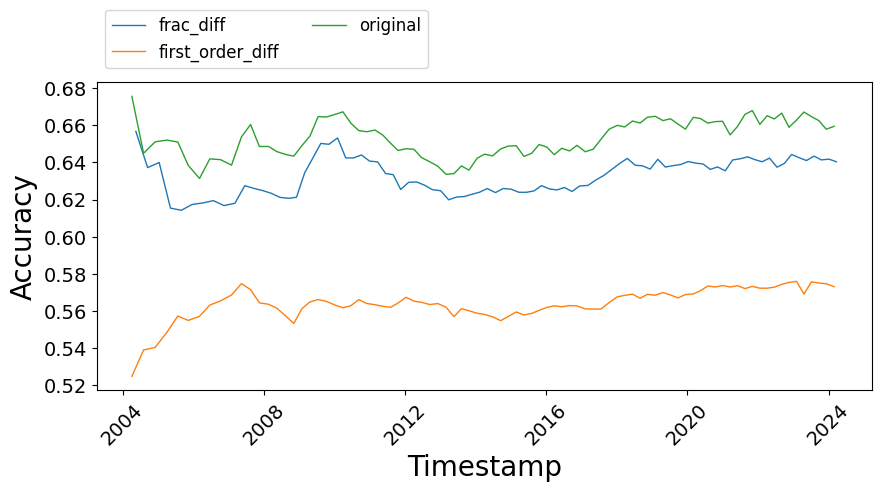

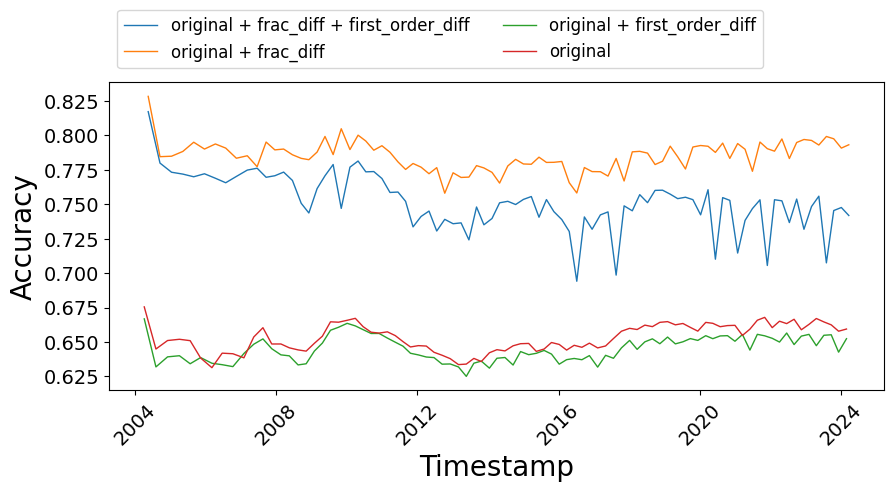

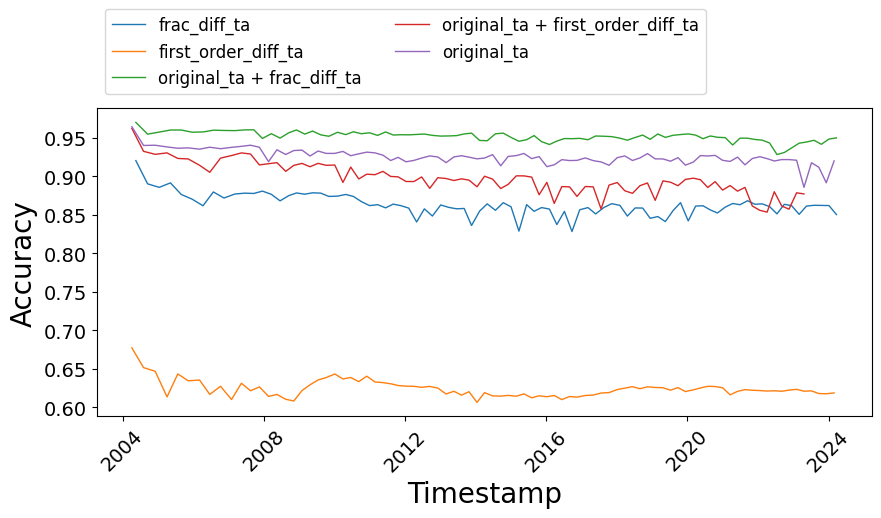

In [ ]:
datasets = ['m4_daily_dataset', 'sp500_run1', 'sp500_run2', 'sp500_run4']
datasets = ['traffic_nips']

ar_res, cr_res = load_results(datasets)

ar_res = impute_ts(ar_res, 'm4_daily_dataset', '1997-07-22', 8531)
cr_res = impute_ts(cr_res, 'm4_daily_dataset', '1997-07-22', 8531)

results = plot_res_build_resdf(ar_res, cr_res)

results = append_stab(ar_res, results, 'adaptation')
results = append_stab(cr_res, results, 'consolidation')
results

In [32]:
results['dataset'] = results['dataset'].str.replace('m4_daily_dataset', 'M4 Daily (Run 4)').str.replace('sp500_run1', 'S\&P 500 (Run 1)').str.replace('sp500_run2', 'S\&P 500 (Run 2)').str.replace('sp500_run4', 'S\&P 500 (Run 3) ')
results['data_form'] = results['data_form'].str.replace('frac_diff', 'FD').str.replace('original', 'O').str.replace('first_order_diff', 'FOD').str.replace('_ta', ' (+df)').str.replace(' +', ',')
results = results[['dataset', 'value_type', 'data_form', 'mean_acc', 'low_acc', 'high_acc', 'stab_coeff_var']]
results

,dataset,value_type,data_form,mean_acc,low_acc,high_acc,stab_coeff_var
0,M4 Daily (Run 4),adaptation,"O, FD, FOD",0.958837,0.915116,0.990698,2.640366
1,M4 Daily (Run 4),adaptation,"O, FD",0.957326,0.845349,0.995349,4.132954
2,M4 Daily (Run 4),adaptation,"O, FOD",0.502791,0.432558,0.556977,7.667620
3,M4 Daily (Run 4),adaptation,O,0.489070,0.422093,0.526744,6.116560
4,S\&P 500 (Run 1),adaptation,FD,0.663071,0.546500,0.849300,8.942310
5,S\&P 500 (Run 1),adaptation,FOD,0.572326,0.489600,0.743100,8.760292
6,S\&P 500 (Run 1),adaptation,O,0.690385,0.552600,0.867700,9.101097
7,S\&P 500 (Run 2),adaptation,"O, FD, FOD",0.795817,0.680800,0.930100,7.275011
8,S\&P 500 (Run 2),adaptation,"O, FD",0.829648,0.740600,0.932700,5.667216
9,S\&P 500 (Run 2),adaptation,"O, FOD",0.683492,0.562800,0.860000,9.072673


In [33]:
print(results.to_latex(index=False, float_format="%.4f"))

\begin{tabular}{lllrrrr}
\toprule
dataset & value_type & data_form & mean_acc & low_acc & high_acc & stab_coeff_var \\
\midrule
M4 Daily (Run 4) & adaptation & O, FD, FOD & 0.9588 & 0.9151 & 0.9907 & 2.6404 \\
M4 Daily (Run 4) & adaptation & O, FD & 0.9573 & 0.8453 & 0.9953 & 4.1330 \\
M4 Daily (Run 4) & adaptation & O, FOD & 0.5028 & 0.4326 & 0.5570 & 7.6676 \\
M4 Daily (Run 4) & adaptation & O & 0.4891 & 0.4221 & 0.5267 & 6.1166 \\
S\&P 500 (Run 1) & adaptation & FD & 0.6631 & 0.5465 & 0.8493 & 8.9423 \\
S\&P 500 (Run 1) & adaptation & FOD & 0.5723 & 0.4896 & 0.7431 & 8.7603 \\
S\&P 500 (Run 1) & adaptation & O & 0.6904 & 0.5526 & 0.8677 & 9.1011 \\
S\&P 500 (Run 2) & adaptation & O, FD, FOD & 0.7958 & 0.6808 & 0.9301 & 7.2750 \\
S\&P 500 (Run 2) & adaptation & O, FD & 0.8296 & 0.7406 & 0.9327 & 5.6672 \\
S\&P 500 (Run 2) & adaptation & O, FOD & 0.6835 & 0.5628 & 0.8600 & 9.0727 \\
S\&P 500 (Run 2) & adaptation & O & 0.6904 & 0.5526 & 0.8677 & 9.1011 \\
S\&P 500 (Run 3)  & adaptation

In [8]:
pd.set_option('display.float_format', '{:.10f}'.format)

In [41]:
1-(1.395/4.853)

0.7125489388007418

In [40]:
95.95-52.71

43.24

In [36]:
results[results['dataset'] == 'm4_daily_dataset']

,data_form,mean_acc,low_acc,high_acc,dataset,value_type,series_num,stab_var,stab_mean,stab_coeff_var
0,original + frac_diff + first_order_diff,0.9466666667,0.9043010753,1.0000000000,m4_daily_dataset,adaptation,1165,0.0008514742,0.9466666667,3.0823975498
1,original + frac_diff,0.9569835278,0.9000000000,0.9822580645,m4_daily_dataset,adaptation,1165,0.0004877468,0.9569835278,2.3077711709
2,original + first_order_diff,0.4789709775,0.4032258065,0.5297872340,m4_daily_dataset,adaptation,1165,0.0013108035,0.4789709775,7.5589173893
3,original,0.5361319124,0.4451612903,0.6580645161,m4_daily_dataset,adaptation,1165,0.0034421959,0.5361319124,10.9432451870
14,original + frac_diff + first_order_diff,0.9464042523,0.9204301075,0.9614695341,m4_daily_dataset,consolidation,1165,0.0001700276,0.9464042523,1.3777898141
15,original + frac_diff,0.9594827002,0.9225806452,0.9709677419,m4_daily_dataset,consolidation,1165,0.0001792780,0.9594827002,1.3954888426
16,original + first_order_diff,0.4943834920,0.4709677419,0.5215053763,m4_daily_dataset,consolidation,1165,0.0001680167,0.4943834920,2.6218765439
17,original,0.5271343382,0.4903225806,0.6150537634,m4_daily_dataset,consolidation,1165,0.0006545012,0.5271343382,4.8532639727


In [35]:
idx = results.loc[results['dataset'] == 'm4_daily_dataset'].loc[ results['value_type'] == 'adaptation'].index
results.loc[idx,'stab_var'] = 0.3

In [8]:
# results.drop(columns=['stab_var', 'stab_mean','series_num'], inplace=True)
results.to_csv('results_runs1_to_4.csv', index=False)

# Tabulate gluonts results

In [8]:
a = 0.8278
b = 0.243
print(f'{(a-b)*100:.2f}')

58.48


In [9]:
import re
import pandas as pd

def parse_to_df_simple(file_path):
    # This single regex pattern captures all required fields for one block.
    # It uses named capture groups for clear column mapping.
    pattern = re.compile(
        r'(?P<Model>\w+)\s+(?P<Trials>\d+).*?on\s+(?P<Dataset>\w+)(?P<Dropped>\s+dropped,|)\s+(?P<Save_Label>\w+)(?P<NoNorm>\s+no norm|)\s+data form.*?'
        r'Runtime:\s*(?P<Runtime>[\d\.]+)\s+minutes.*?'
        r'Prediction length:\s*(?P<Pred_Len>\d+),\s*Context length:\s*(?P<Context_Len>\d+).*?'
        r'Params:\s*(?P<Params>\{.*?\}).*?'
        r'MASE MEAN:\s*(?P<MASE_MEAN>[\d\.\-]+)\s+MASE STD:\s*(?P<MASE_STD>[\d\.\-]+).*?'
        r'sMAPE MEAN:\s*(?P<sMAPE_MEAN>[\d\.\-]+)\s+sMAPE STD:\s*(?P<sMAPE_STD>[\d\.\-]+).*?'
        r'RMSE MEAN:\s*(?P<RMSE_MEAN>[\d\.\-]+)\s+RMSE STD:\s*(?P<RMSE_STD>[\d\.\-]+)',
        re.DOTALL | re.MULTILINE
    )

    with open(file_path, 'r') as f:
        content = f.read()

    # Find all matches (one for each result block)
    parsed_data = [m.groupdict() for m in pattern.finditer(content)]

    # Create DataFrame and convert appropriate columns to numeric types
    df = pd.DataFrame(parsed_data)
    numeric_cols = df.columns.difference(['Model', 'Dataset', 'Save_Label', 'Params', 'Dropped', 'NoNorm'])
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric)
    
    return df

# Example Usage:
file_path = "gluonts_results.txt"
# Assume the file exists and has data
df_results = parse_to_df_simple(file_path)

# Output
print(df_results.head())
# df_results.to_csv("gluonts_results.csv", index=False) # Uncomment to save to CSV

         Model  Trials Dataset    Dropped        Save_Label NoNorm    Runtime  \
0  feedforward      15   sp500              original_values         51.026491   
1  feedforward      15   sp500   dropped,   original_values         58.344638   
2  feedforward      15   sp500             fd_target_values         43.130271   
3  feedforward      15   sp500   dropped,  fd_target_values         57.491492   
4  feedforward      15   sp500                    fd_in_fdr         41.024522   

   Pred_Len  Context_Len                                             Params  \
0        78          390  {'num_layers': 1, 'hidden_dim_0': 86, 'trainer...   
1        78          390  {'num_layers': 2, 'hidden_dim_0': 98, 'hidden_...   
2        78          390  {'num_layers': 1, 'hidden_dim_0': 18, 'trainer...   
3        78          390  {'num_layers': 1, 'hidden_dim_0': 88, 'trainer...   
4        78          390  {'num_layers': 3, 'hidden_dim_0': 98, 'hidden_...   

   MASE_MEAN  MASE_STD  sMAPE_MEAN  sM

In [10]:
# replace dropped with true when value is a non empty string
df_results['Dropped'] = df_results['Dropped'].apply(lambda x: True if x else False)
df_results['NoNorm'] = df_results['NoNorm'].apply(lambda x: True if x else False)

In [11]:
df_results[['MASE_MEAN', 'MASE_STD']] = np.round(df_results[['MASE_MEAN', 'MASE_STD']], 4)
df_results['result_print'] = df_results.apply(lambda x: f"{x['MASE_MEAN']} ± {x['MASE_STD']}", axis=1)

df_results.to_csv("gluonts_results.csv", index=False)
# for i,row in df_results[-18:].iterrows():
#     print(f"{row['Model']} {row['Dataset']} {row['Pred_Len']} {row['Context_Len']} {row['Save_Label']} {row['MASE_MEAN']} ± {row['MASE_STD']}")

In [12]:
df_results

,Model,Trials,Dataset,Dropped,Save_Label,NoNorm,Runtime,Pred_Len,Context_Len,Params,MASE_MEAN,MASE_STD,sMAPE_MEAN,sMAPE_STD,RMSE_MEAN,RMSE_STD,result_print
0,feedforward,15,sp500,False,original_values,False,51.026491,78,390,"{'num_layers': 1, 'hidden_dim_0': 86, 'trainer...",1.7589,0.2936,0.015349,0.002548,1.833141,0.300789,1.7589 ± 0.2936
1,feedforward,15,sp500,True,original_values,False,58.344638,78,390,"{'num_layers': 2, 'hidden_dim_0': 98, 'hidden_...",1.7193,0.8260,0.015420,0.007369,1.808967,0.821002,1.7193 ± 0.826
2,feedforward,15,sp500,False,fd_target_values,False,43.130271,78,390,"{'num_layers': 1, 'hidden_dim_0': 18, 'trainer...",12.3642,0.0761,0.115300,0.000750,12.072583,0.072255,12.3642 ± 0.0761
3,feedforward,15,sp500,True,fd_target_values,False,57.491492,78,390,"{'num_layers': 1, 'hidden_dim_0': 88, 'trainer...",0.2716,0.0389,0.002390,0.000342,0.335187,0.054640,0.2716 ± 0.0389
4,feedforward,15,sp500,False,fd_in_fdr,False,41.024522,78,390,"{'num_layers': 3, 'hidden_dim_0': 98, 'hidden_...",2.7736,1.0725,0.024091,0.009202,2.729128,1.004735,2.7736 ± 1.0725
5,feedforward,15,sp500,True,fd_in_fdr,False,29.115324,78,390,"{'num_layers': 2, 'hidden_dim_0': 50, 'hidden_...",1.0684,0.7476,0.009448,0.006667,1.121232,0.738947,1.0684 ± 0.7476
6,transformer,15,sp500,False,original_values,False,280.230243,78,390,"{'model_dim_num_heads_pair': (22, 1), 'inner_f...",2.6144,0.3653,0.022738,0.003138,2.552176,0.348023,2.6144 ± 0.3653
7,transformer,15,sp500,False,fd_target_values,False,214.188710,78,390,"{'model_dim_num_heads_pair': (52, 4), 'inner_f...",1.9447,0.7587,0.017162,0.006705,2.155974,0.745449,1.9447 ± 0.7587
8,transformer,15,sp500,True,original_values,False,530.381358,78,390,"{'model_dim_num_heads_pair': (32, 2), 'inner_f...",0.5163,0.2985,0.004625,0.002665,0.589148,0.315551,0.5163 ± 0.2985
9,transformer,15,sp500,False,fd_in_fdr,False,303.282211,78,390,"{'model_dim_num_heads_pair': (88, 4), 'inner_f...",2.5539,0.3467,0.022229,0.002983,2.507522,0.328076,2.5539 ± 0.3467


In [8]:
groups = df_results[['Model', 'Pred_Len', 'Context_Len', 'result_print', 'Dropped','NoNorm']].groupby(['Model', 'Pred_Len', 'Context_Len', 'Dropped', 'NoNorm'])

for name, group in groups:
    print(name, group)
    break

('feedforward', 12, 390, False, False)           Model  Pred_Len  Context_Len     result_print  Dropped  NoNorm
29  feedforward        12          390  2.3759 ± 1.0347    False   False
30  feedforward        12          390  8.3912 ± 0.5021    False   False
31  feedforward        12          390  3.6947 ± 4.4133    False   False


In [72]:
df_1_dataset = df_results[df_results['Dataset'] == 'sp500'] # m4_daily_dataset
# m4_res = m4_res[m4_res['Pred_Len'] == 14]
df_1_dataset.drop(columns=['Trials', 'Runtime', 'Params', 'sMAPE_MEAN', 'sMAPE_STD', 'RMSE_MEAN', 'RMSE_STD'], inplace=True)
df_1_dataset

/tmp/ipykernel_3340/4238173228.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1_dataset.drop(columns=['Trials', 'Runtime', 'Params', 'sMAPE_MEAN', 'sMAPE_STD', 'RMSE_MEAN', 'RMSE_STD'], inplace=True)


,Model,Dataset,Save_Label,Pred_Len,Context_Len,MASE_MEAN,MASE_STD
33,transformer,sp500,original_values,12,390,0.415443,0.186117
34,transformer,sp500,fd_target_values,12,390,0.161628,0.042724
35,transformer,sp500,fd_in_fdr,12,390,0.697601,0.213665
36,transformer,sp500,fd_target_values,78,390,0.369107,0.171328
37,transformer,sp500,fd_in_fdr,78,390,0.992189,0.322756
38,transformer,sp500,original_values,78,390,0.894987,0.199357


In [74]:
df = df_1_dataset
# --- Step 2: Combine Mean/STD and Pivot the Data ---

# Define metric roots (MASE, sMAPE, RMSE) and all ID columns
metrics = ['MASE']
id_cols = ['Model', 'Dataset', 'Pred_Len', 'Context_Len']
pivot_cols = id_cols + ['Save_Label']

# 1. Combine all Mean and STD columns into single string columns
for m in metrics:
    df[m] = df[f'{m}_MEAN'].round(4).astype(str) + ' ± ' + df[f'{m}_STD'].round(4).astype(str)
    df = df.drop(columns=[f'{m}_MEAN', f'{m}_STD'])


# 2. Reshape to put Save_Label into column headers
# We use a merge loop instead of melt/pivot to simplify the code length
df_pivoted = df[id_cols].drop_duplicates().set_index(id_cols) # Start with unique ID rows

for label in df['Save_Label'].unique():
    # Filter the DataFrame for the current label
    df_temp = df[df['Save_Label'] == label].set_index(id_cols)
    
    # Rename metric columns with the label prefix
    df_temp = df_temp[metrics].rename(
        columns=lambda x: f'{label}' # _{x} if using multiple metrics
    )
    
    # Merge into the pivoted result
    df_pivoted = df_pivoted.merge(df_temp, left_index=True, right_index=True, how='left')

# 3. Final cleanup
df_final = df_pivoted.reset_index()

df_final.drop_duplicates(subset='original_values', keep='last', inplace=True) # duplicates in this case due to rerun after changing FD type, on m4 only
df_final.drop(columns=['Dataset'], inplace=True)

/tmp/ipykernel_3340/1090424233.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[m] = df[f'{m}_MEAN'].round(4).astype(str) + ' ± ' + df[f'{m}_STD'].round(4).astype(str)


In [75]:
df_final.sort_values(by=['Model', 'Pred_Len', 'Context_Len'], inplace=True)
df_final.reset_index(drop=True, inplace=True)
df_final

,Model,Pred_Len,Context_Len,original_values,fd_target_values,fd_in_fdr
0,transformer,12,390,0.4154 ± 0.1861,0.1616 ± 0.0427,0.6976 ± 0.2137
1,transformer,78,390,0.895 ± 0.1994,0.3691 ± 0.1713,0.9922 ± 0.3228


# Extra Plots

In [14]:
ar_res.keys()

dict_keys(['m4_daily_dataset', 'sp500_run1', 'sp500_run2', 'sp500_run4'])

In [19]:
dataset = 'sp500_run2' 
series_num = '1'
data_form = 'original + frac_diff' # 'original_ta + frac_diff_ta'#
metric = 'mase_mean'
metric= 'accuracy_mean'
ar_scores = [res[metric] for res in ar_res[dataset][series_num][data_form]]
ar_ts = [ res['last_ts'] for res in ar_res[dataset][series_num][data_form] ]
cr_scores = [res[metric] for res in cr_res[dataset][series_num][data_form]]
cr_ts = [ res['last_ts'] for res in cr_res[dataset][series_num][data_form] ]

In [39]:
a_pct_change = np.diff(ar_scores) / ar_scores[:-1] * 100
c_pct_change = np.diff(cr_scores) / cr_scores[:-1] * 100

out_line = 0
for a, c in zip(a_pct_change[1:], c_pct_change):
    if (a > 0 and c < 0) or (a < 0 and c > 0):
        out_line += 1
print(out_line, len(c_pct_change), (out_line / len(c_pct_change)) * 100)

44 86 51.162790697674424


In [64]:
a_thresh, c_thresh = 7, 2#np.mean(abs(a_pct_change)), np.mean(abs(c_pct_change))

In [65]:
count = 0
out_line = 0
for a, c in zip(a_pct_change[1:], c_pct_change):
    if (abs(a) > a_thresh):
        count += 1
        if (a > 0 and c < 0) or (a < 0 and c > 0):
            out_line += 1
    
print(out_line, count, (out_line / count) * 100)

6 13 46.15384615384615


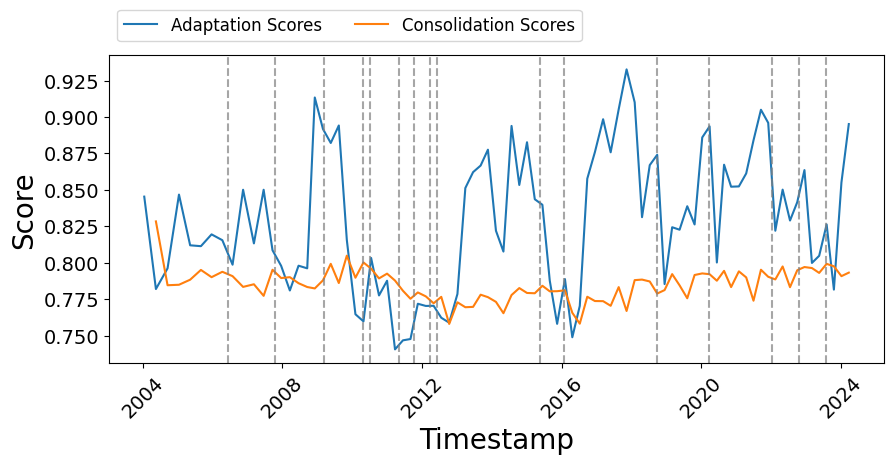

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 4))
# sns.set_theme() 

sns.lineplot(y=ar_scores, x=ar_ts, label='Adaptation Scores') 
sns.lineplot(y=cr_scores, x=cr_ts, label='Consolidation Scores')

for timestamp in regs:
    plt.axvline(x=timestamp, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)

# Set the title and axis labels using matplotlib functions
# plt.title('Comparison of Differencing Effect on Non-Stationary Series', fontsize=24, pad=5)
plt.xlabel('Timestamp', fontsize=20)
plt.ylabel('Score', fontsize=20)

# Size the tick labels
plt.xticks(fontsize=14, rotation=45) # Adjust X-axis tick label size
plt.yticks(fontsize=14) # Adjust Y-axis tick label size

plt.legend(fontsize=12, bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", ncol=2)
plt.savefig(f'figures/a_vs_c_sp500_run3_o_fd.png', bbox_inches='tight')
plt.show()

In [15]:
# PZ

from pz_algorithm import pz_algorithm

import pandas as pd
import pickle

with open('/mnt/c/Users/resha/Documents/Github/balancing_framework/spy5m_bintp_labelled.pkl', 'rb') as f:
    df_original = pickle.load(f) # ohlv + transactions + labels + bintp labels
df = df_original[["volume", "vwap", "open", "close", "high", "low", "transactions", "tp_0.004"]].rename(columns={"tp_0.004": "label"}) # 0.01 0.001
# df

peaks, troughs = pz_algorithm(df['close'], iterations=6)
print(f'Peaks: {len(peaks)}, Troughs: {len(troughs)}')

Peaks: 8, Troughs: 8


In [16]:
regs = pd.concat([peaks, troughs]).sort_index().index

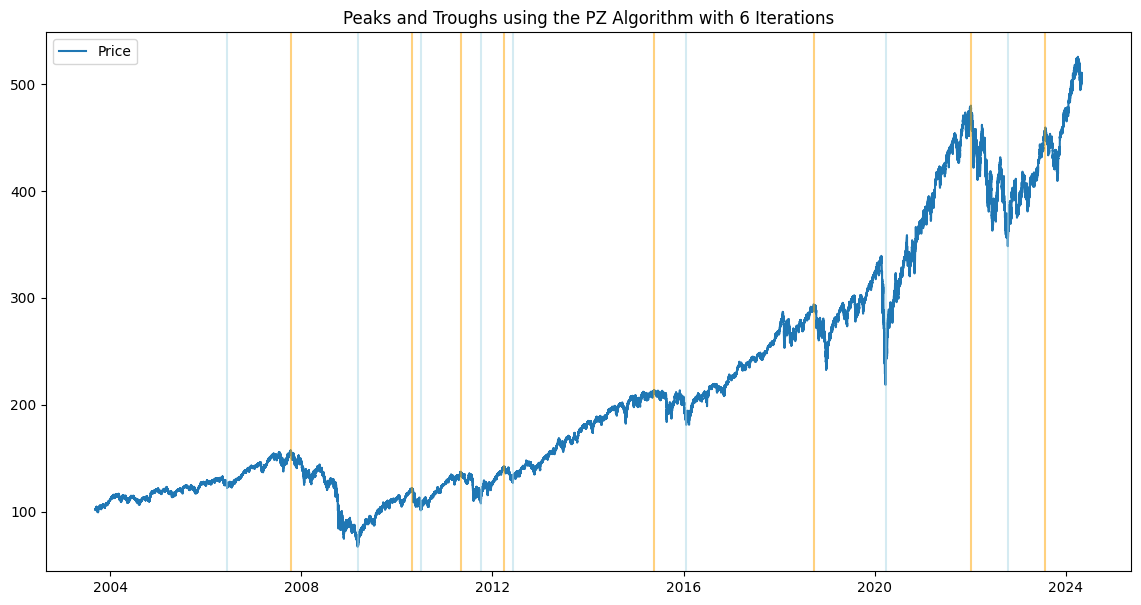

In [21]:

# plot the peaks and troughs
import matplotlib.pyplot as plt
plt.figure(figsize=(14,7))
plt.plot(df['close'], label='Price')
# use orange vertical lines for peaks and light blue vertical lines for troughs
for peak in peaks.index:
    plt.axvline(peak, color='orange', alpha=0.5)
for trough in troughs.index:
    plt.axvline(trough, color='lightblue', alpha=0.5)
plt.title('Peaks and Troughs using the PZ Algorithm with 6 Iterations')
plt.legend()
plt.show()

In [2]:
%cd ../

/mnt/c/Users/resha/Documents/Github/balancing_framework


In [10]:
import pickle
import pandas

with open("/mnt/c/Users/resha/Downloads/adaptation_results_['fd'].pkl", 'rb') as f:
    ar_results = pickle.load(f)

In [11]:
len(ar_results)

27